In [13]:
import sys
sys.path.append("..")

from utils import *

# Hypothesetoetsen

## Toetsen voor het gemiddelde $\mu$

In [14]:
def determine_critical_values(test_type, mu_0, sample_std, alpha, xmin, xmax):
    if test_type == "tweezijdig":
        # Kritieke waarde onder H0 (voor tweezijdige toets)
        z_alpha = norm.ppf(1 - alpha / 2)
        critical_value_left = mu_0 - z_alpha * sample_std
        critical_value_right = mu_0 + z_alpha * sample_std
    elif test_type == "linkszijdig":
        # Kritieke waarde onder H0 (voor linkszijdige toets)
        z_alpha = norm.ppf(1 - alpha)
        critical_value_left = mu_0 - z_alpha * sample_std
        critical_value_right = xmax
    else:
        # Kritieke waarde onder H0 (voor rechtszijdige toets)
        z_alpha = norm.ppf(1 - alpha)
        critical_value_left = xmin
        critical_value_right = mu_0 + z_alpha * sample_std
    return critical_value_left, critical_value_right
    
def plot_hypothesis_testing(test_type="tweezijdig", mu_0=0, mu_1=None, sigma=1, alpha=0.05, sample_size=30, test_stat=None, width=12, height=7.5, filename="test.txt"):
    fig, ax = plt.subplots(figsize=(width, height))
    sample_std = sigma / np.sqrt(sample_size)

    if mu_1:
        maxmu = max(mu_0, mu_1)
        minmu = min(mu_0, mu_1)
    else:
        maxmu, minmu = mu_0, mu_0
    x = np.linspace(minmu - 4 * sample_std, maxmu + 4 * sample_std, 1_000)   

    # H_0 specifics
    pdf_H0 = norm.pdf(x, mu_0, sample_std)

    # H1 specifics
    if mu_1:
        pdf_H1 = norm.pdf(x, mu_1, sample_std)

    # Draw horizontal lines indicating the regions
    xmin, xmax = x[0], x[-1]

    ax.set_xlabel('Toetsingsgrootheid $\\overline{x}$')
    ax.set_ylabel('Kansdichtheidsfunctie $f(\\overline{x})$')
    
    # Plot instellen
    ax.plot(x, pdf_H0, color=primary_plot_color, alpha=opacity_level, label="Kansverdeling van $\\overline{X}$ onder $H_0$")
    ax.plot([mu_0, mu_0], [0, norm.pdf(mu_0, mu_0, sample_std)], color=primary_plot_color, linestyle='--')

    ymin, ymax = ax.get_ylim()
    ytext, offset = get_y_annotation(ax)
    ymu = 1/4 * ytext
    ylines = 1/2 * ytext
    ax.set_ylim(ymin - 2 * offset, ymax)

    ax.text(mu_0, ymu, "$\\mu_0$", color=primary_plot_color, ha="center", va="center")

    if mu_1:
        ax.plot(x, pdf_H1, color=secondary_plot_color, alpha=opacity_level, label="Kansverdeling van $\\overline{X}$ onder $H_1$")
        ax.plot([mu_1, mu_1], [0, norm.pdf(mu_1, mu_1, sample_std)], color=secondary_plot_color, linestyle='--')
        ax.text(mu_1, ymu, "$\\mu_1$", color=secondary_plot_color, ha="center", va="center")

    # Determine the critical values
    critical_value_left, critical_value_right = determine_critical_values(test_type, mu_0, sample_std, alpha, xmin, xmax)

    # Shade the critical region
    ax.plot([critical_value_left, critical_value_left], [0, norm.pdf(critical_value_left, mu_0, sample_std)], color=critical_color, linestyle='-')#, label='Kritieke grens links')
    ax.fill_between(x, 0, pdf_H0, where=(x < critical_value_left), color=critical_color, alpha=opacity_level, label=f'Type-I fout ($\\alpha$): {pretty_print(alpha)}')
    ax.plot([critical_value_right, critical_value_right], [0, norm.pdf(critical_value_right, mu_0, sample_std)], color=critical_color, linestyle='-')#, label='Kritieke grens rechts')
    ax.fill_between(x, 0, pdf_H0, where=(x > critical_value_right), color=critical_color, alpha=opacity_level)

    # Bereken de type-II fout en arceer de bijbehorende oppervlaktes (wat is de kans op een waarde in het acceptatiegebied?)
    if mu_1:
        beta = norm.cdf(critical_value_right, loc=mu_1, scale=sample_std) - norm.cdf(critical_value_left, loc=mu_1, scale=sample_std)
        ax.fill_between(x, 0, pdf_H1, where=((x < critical_value_right) & (x > critical_value_left)), color=secondary_plot_color, alpha=opacity_level, label=f'Type II fout ($\\beta$): {beta:.3f}')

    if test_type == "tweezijdig":
        label_critical_region = f"Kritiek gebied: $(-\\infty; {pretty_print(critical_value_left)}]$ en $[{pretty_print(critical_value_right)}; \\infty)$"        
        plt.suptitle(f'$H_0$: $\\mu={mu_0}$ vs. $H_1$: $\\mu \\neq {mu_0}$ (tweezijdige hypothesetoets)', fontsize=20)
        
    elif test_type == "rechtszijdig":
        label_critical_region = f"Kritiek gebied: $[{pretty_print(critical_value_right)}; \\infty)$"               
        plt.suptitle(f'$H_0$: $\\mu\\leq{mu_0}$ vs. $H_1$: $\\mu > {mu_0}$ (rechtszijdige hypothesetoets)', fontsize=20)
        
    else: # linkszijdig
        label_critical_region = f"Kritiek gebied: $(-\\infty; {pretty_print(critical_value_left)}]$"        
        plt.suptitle(f'$H_0$: $\\mu\\geq{mu_0}$ vs. $H_1$: $\\mu < {mu_0}$ (linkszijdige hypothesetoets)', fontsize=20)

    # Teken het acceptatiegebied
    ax.hlines(ylines, critical_value_left, critical_value_right, color=acceptable_color, linewidth=5)
    ax.text((critical_value_left + critical_value_right) / 2, ytext, 'Accepteer $H_0$', color=acceptable_color, fontsize=11, ha='center')
    
    # Teken het kritieke gebied
    ax.hlines(ylines, xmin, critical_value_left, color=critical_color, linewidth=5, label=label_critical_region)
    ax.hlines(ylines, critical_value_right, xmax, color=critical_color, linewidth=5)
    if critical_value_left != xmin:
        ax.text((critical_value_left + xmin) / 2, ytext, 'Verwerp $H_0$', color=critical_color, fontsize=11, ha='center')
    if critical_value_right != xmax:
        ax.text((critical_value_right + xmax) / 2, ytext, 'Verwerp $H_0$', color=critical_color, fontsize=11, ha='center')
    
    ax.set_title(f"Kansdichtheidsfunctie van het steekproefgemiddelde $\\overline{{X}}\\sim N(\\mu={mu_0}; \\sigma = \\frac{{{sigma}}}{{\\sqrt{{{sample_size}}}}})$")
    
    if test_stat:
        ax.plot([test_stat, test_stat], [0, norm.pdf(test_stat, mu_0, sample_std)], color=primary_plot_color, linestyle="--")
        ax.text(test_stat, ytext, '$\\overline{x}$', color='black', fontsize=11, ha='center')
        
    ax.legend()
    plt.savefig(filename)

### Voorbeeld gebruik

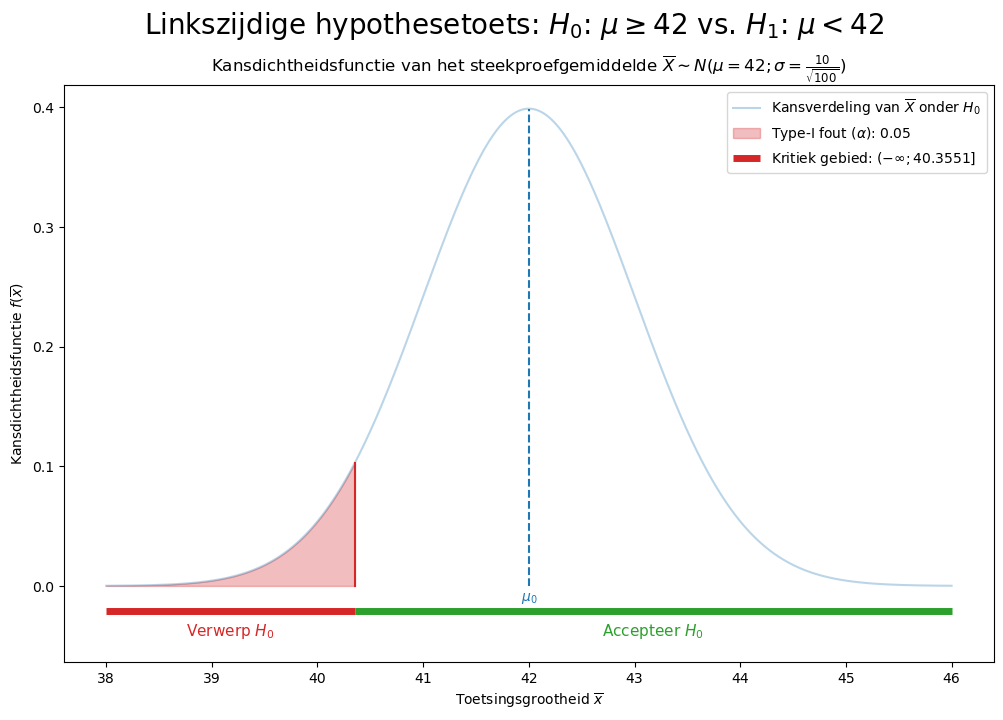

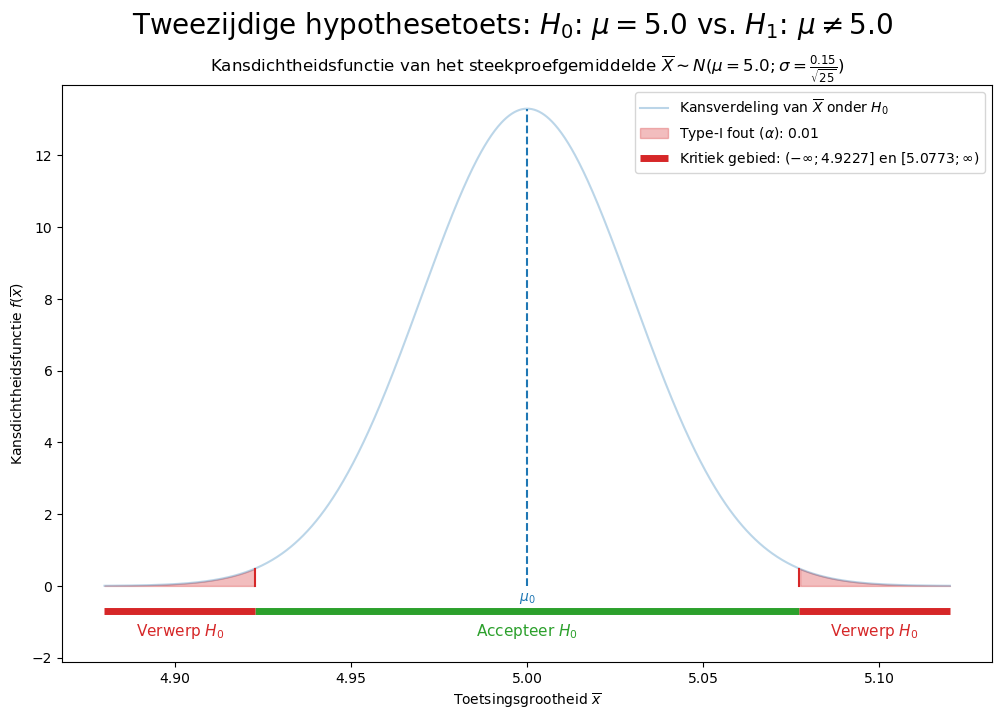

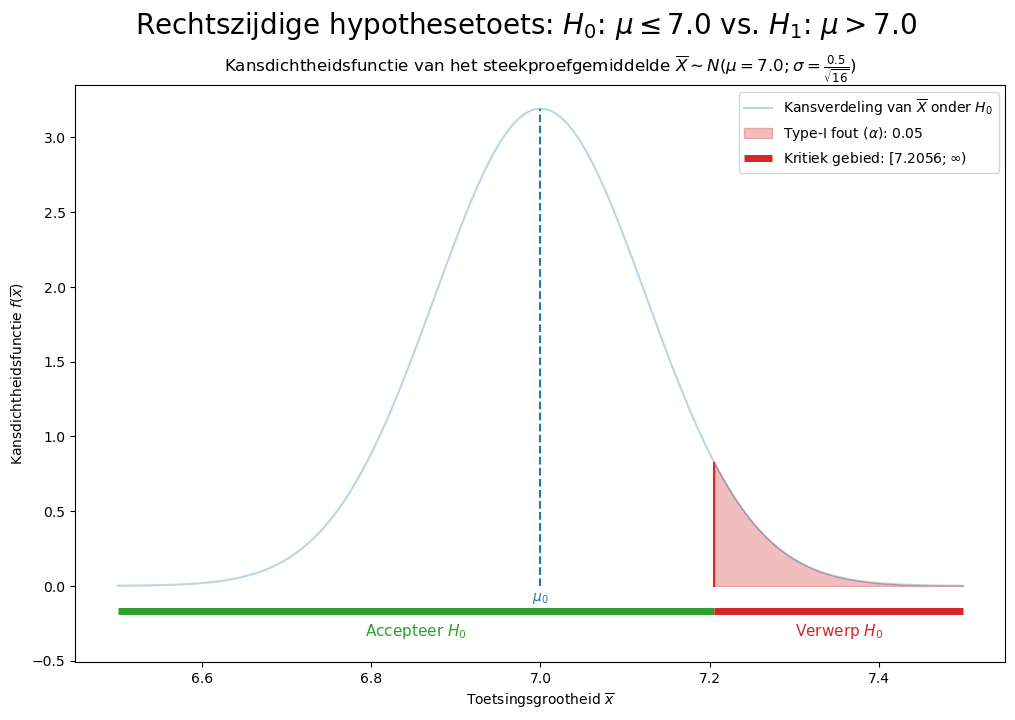

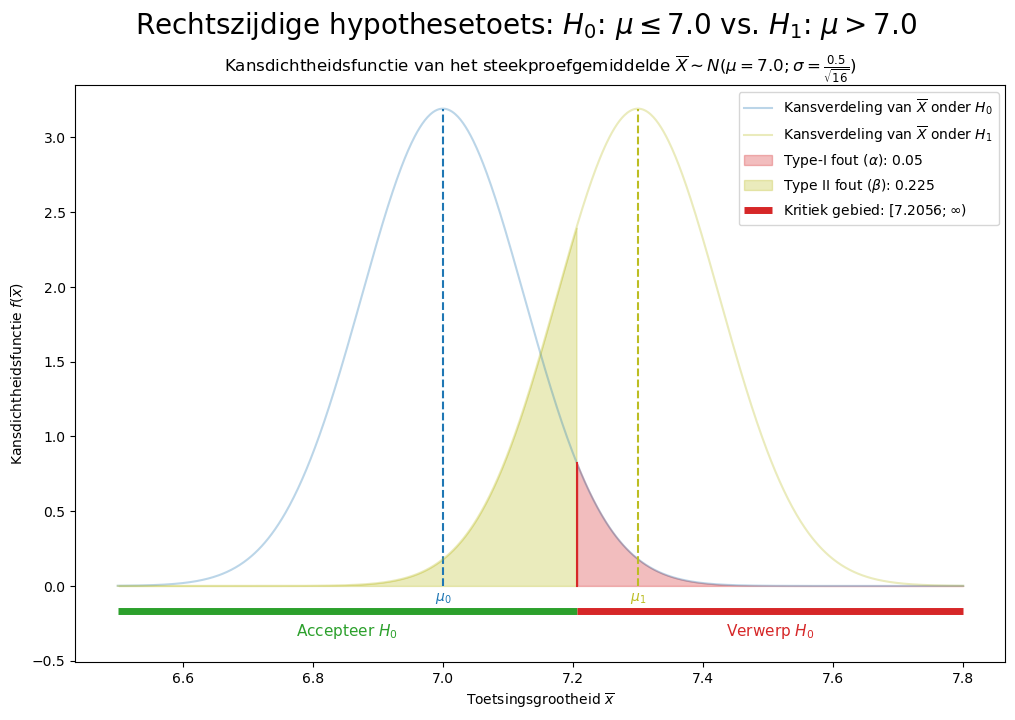

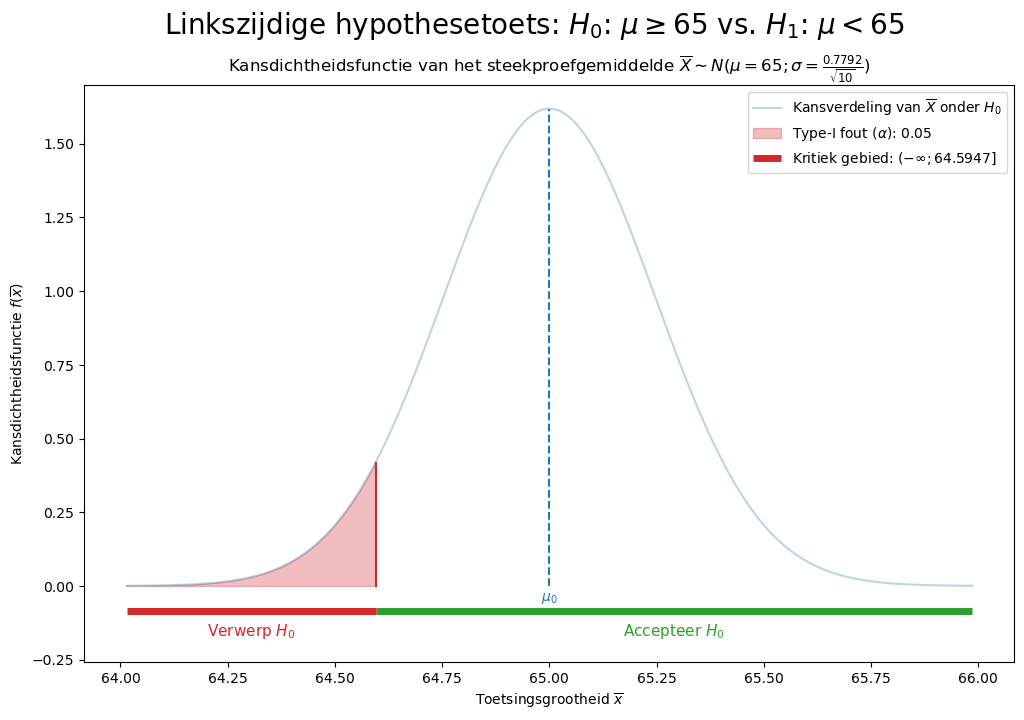

In [15]:
plot_hypothesis_testing(test_type="linkszijdig", mu_0=42, mu_1=None, sigma=10, alpha=0.05, sample_size=100, test_stat=None, filename=FIGURE_PATH + "test_hypothesis_1.png")
plot_hypothesis_testing(test_type="tweezijdig", mu_0=5.0, mu_1=None, sigma=0.15, alpha=0.01, sample_size=25, test_stat=None, filename=FIGURE_PATH + "test_hypothesis_2.png")
plot_hypothesis_testing(test_type="rechtszijdig", mu_0=7.0, mu_1=None, sigma=0.5, alpha=0.05, sample_size=16, test_stat=None, filename=FIGURE_PATH + "test_hypothesis_3.png")
plot_hypothesis_testing(test_type="rechtszijdig", mu_0=7.0, mu_1=7.30, sigma=0.5, alpha=0.05, sample_size=16, test_stat=None, filename=FIGURE_PATH + "test_hypothesis_4.png")

plot_hypothesis_testing(test_type="linkszijdig", mu_0=65, sigma=0.7792, alpha=0.05, sample_size=10, test_stat=None, filename=FIGURE_PATH + "test_hypothesis_5.png")